In [11]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
import os
import math
import shutil
import pandas as pd

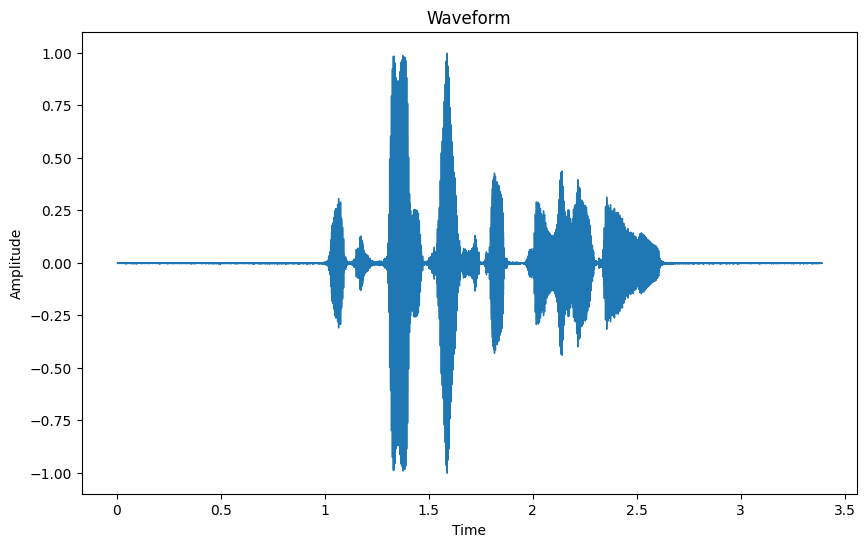

In [12]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load audio file
audio_file_path = "audio-for-lstm/audio/1/LA_T_1003665.flac"
signal, sample_rate = librosa.load(audio_file_path, sr=None)

# Plot waveform
plt.figure(figsize=(10, 6))
librosa.display.waveshow(signal, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [13]:
signal

array([ 3.0517578e-05,  3.0517578e-05,  3.0517578e-05, ...,
       -3.6621094e-04, -1.2207031e-04, -9.1552734e-05], dtype=float32)

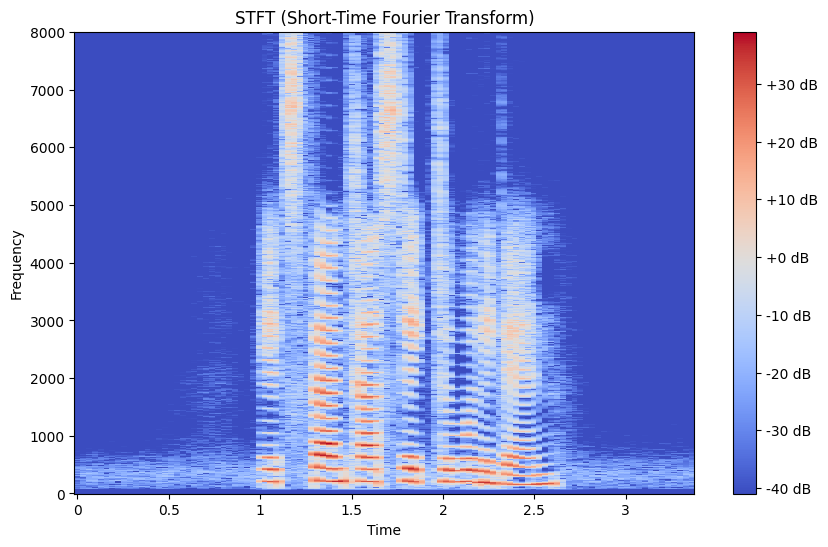

In [14]:
stft = librosa.stft(signal)
stft_db = librosa.amplitude_to_db(np.abs(stft))
plt.figure(figsize=(10, 6))
librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT (Short-Time Fourier Transform)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [15]:
stft_db

array([[-40.978157, -40.978157, -40.978157, ..., -40.978157, -40.978157,
        -40.978157],
       [-40.978157, -40.978157, -40.978157, ..., -40.978157, -40.978157,
        -40.978157],
       [-40.978157, -40.978157, -40.978157, ..., -40.978157, -40.978157,
        -40.978157],
       ...,
       [-40.978157, -40.978157, -40.978157, ..., -40.978157, -40.978157,
        -40.978157],
       [-40.978157, -40.978157, -40.978157, ..., -40.978157, -40.978157,
        -40.978157],
       [-40.978157, -40.978157, -40.978157, ..., -40.978157, -40.978157,
        -40.978157]], dtype=float32)

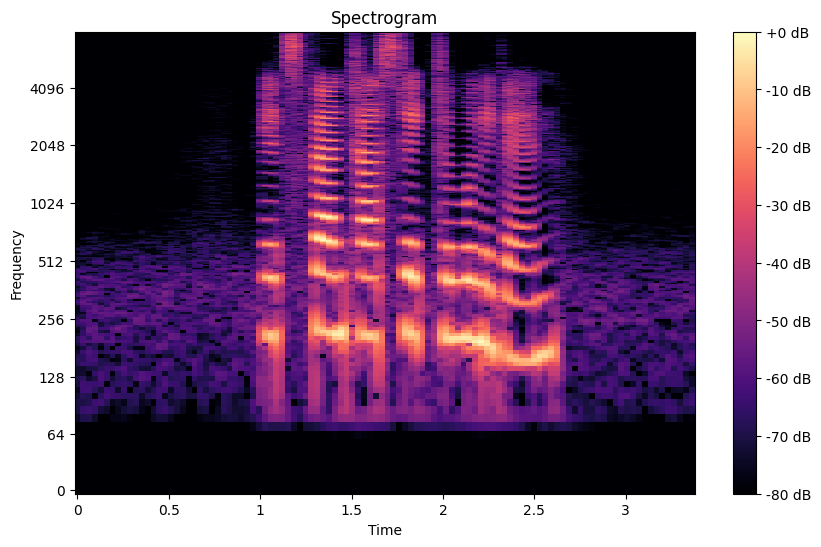

In [16]:
# Compute spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)[0]
plt.figure(figsize=(10, 6))
spectrogram = np.abs(librosa.stft(signal))**2
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [17]:
BASE_PATH = 'archive/LA/LA'

In [18]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',sep=" ", header=None)

In [19]:
train_df.head(5)

,0,1,2,3,4
0,k1,k1,-,-,bonafide
1,k10,k10,-,-,bonafide
2,k11,k11,-,-,bonafide
3,k12,k12,-,-,bonafide
4,k13_0,k13_0,-,-,bonafide


In [20]:
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df.head(5)

,speaker_id,filename,system_id,class_name
0,k1,k1,-,bonafide
1,k10,k10,-,bonafide
2,k11,k11,-,bonafide
3,k12,k12,-,bonafide
4,k13_0,k13_0,-,bonafide


In [21]:
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32')
print('len Train', len(train_df))
train_df.tail(5)

len Train 25987


,speaker_id,filename,system_id,class_name,filepath,target
25982,sp78_0,sp78_0,-,spoof,archive/LA/LA/ASVspoof2019_LA_train/flac/sp78_...,1
25983,sp78_1,sp78_1,-,spoof,archive/LA/LA/ASVspoof2019_LA_train/flac/sp78_...,1
25984,sp79,sp79,-,spoof,archive/LA/LA/ASVspoof2019_LA_train/flac/sp79....,1
25985,sp8,sp8,-,spoof,archive/LA/LA/ASVspoof2019_LA_train/flac/sp8.flac,1
25986,sp9,sp9,-,spoof,archive/LA/LA/ASVspoof2019_LA_train/flac/sp9.flac,1


In [22]:
DATASET_PATH = "/audio"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [23]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):

    
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        
        if dirpath is not dataset_path:

            
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            
            for f in filenames:

                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                
                for d in range(num_segments):

                    
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # Extract MFCCs
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)

    # Save MFCCs as JSON
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [24]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


In [25]:
from tensorflow.keras.models import load_model
import tensorflow as tf

In [26]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras

DATA_PATH = "audio-for-lstm/data.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    print(len(X))
    print(len(X_train))
    print(len(X_test))
    print(len(X_validation))
    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):

    model = keras.Sequential()

    # 2 GRU layers
    model.add(keras.layers.GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.GRU(64)) 

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

In [28]:
if __name__ == "__main__":

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=250,callbacks=[early_stopping],
)
    model.save("fakeaudio.h5")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

1248
748
312
188
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 130, 64)           15168     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 44,418
Trainable params: 44,418
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
24/24 [================

10/10 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       142
           1       0.74      0.79      0.77       170

    accuracy                           0.74       312
   macro avg       0.74      0.73      0.73       312
weighted avg       0.74      0.74      0.74       312

24/24 [==============================] - 0s 16ms/step - loss: 0.4128 - accuracy: 0.8235


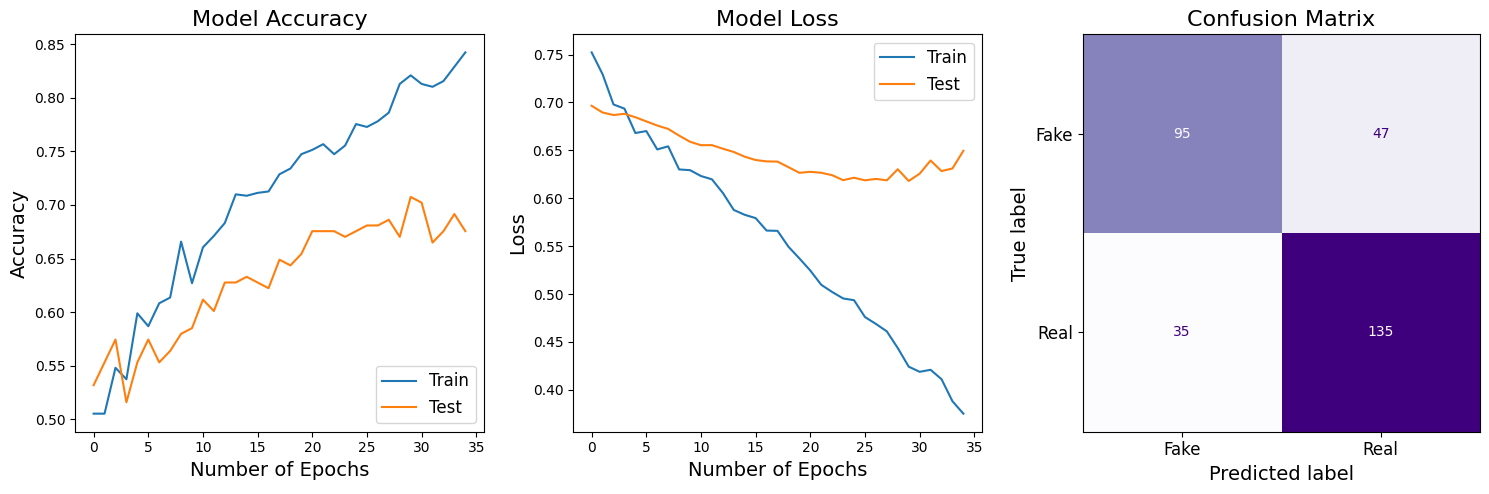

In [29]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  

# Plot accuracy
axs[0].plot(history.history["accuracy"], label="Train")
axs[0].plot(history.history["val_accuracy"], label="Test")
axs[0].set_ylabel("Accuracy",fontsize=14)
axs[0].set_xlabel("Number of Epochs",fontsize=14)
axs[0].legend(loc="lower right",fontsize=12)
axs[0].set_title("Model Accuracy", fontsize=16)

# Plot loss
axs[1].plot(history.history["loss"], label="Train")
axs[1].plot(history.history["val_loss"], label="Test")
axs[1].set_ylabel("Loss", fontsize=14)
axs[1].set_xlabel("Number of Epochs",fontsize=14)
axs[1].legend(loc="upper right", fontsize=12)
axs[1].set_title("Model Loss", fontsize=16)

# Plot confusion matrix
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
loss = model.evaluate(X_train, y_train)
cf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['Fake', 'Real'])
disp.plot(ax=axs[2], cmap='Purples')
disp.ax_.set_title('Confusion Matrix', fontsize=16, fontweight='medium')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('Predicted label', fontsize=14)
disp.ax_.set_ylabel('True label', fontsize=14)
disp.ax_.set_xticklabels(['Fake', 'Real'], fontsize=12)
disp.ax_.set_yticklabels(['Fake', 'Real'], fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()